# <center>Benchmark compression</center>

## <center> Introduction</center>

Ce notebook sert à exécuter des commandes `ffmpeg` afin de tester les différents paramètres et d'en tirer rapidement des métriques pour améliorer la commande de compression utilisée.

Pour paramétrer, donner ci-dessous :
- le chemin vers une vidéo
- le conteneur de sortie (par défaut, .m4v)
- le dossier de sortie des vidéos compressées (par défaut le dossier courant)
- les commandes à exécuter

Après l'exécution des commandes, paramétrer les tracés dans la cellule correspondante.

In [49]:
file_in = "/data/bench/A008_11030611_C007.mov"
format_out = ""
destination = ""

commands = ["ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -acodec aac -strict experimental $out",                #4:2:2 10-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -vf format=yuv422p -acodec aac -strict experimental $out",     #4:2:2 8-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -vf format=yuv420p10le -acodec aac -strict experimental $out", #4:2:0 10-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -vf format=yuv420p -acodec aac -strict experimental $out",     #4:2:0 8-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -vf format=yuv411p -acodec aac -strict experimental $out",     #4:1:1 8-bit
    
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset superfast -acodec aac -strict experimental $out",                        #4:2:2 10-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset superfast -vf format=yuv422p -acodec aac -strict experimental $out",     #4:2:2 8-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset superfast -vf format=yuv420p10le -acodec aac -strict experimental $out", #4:2:0 10-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset superfast -vf format=yuv420p -acodec aac -strict experimental $out",     #4:2:0 8-bit
    "ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset superfast -vf format=yuv411p -acodec aac -strict experimental $out",     #4:1:1 8-bit   
]

## <center>Exécution des commandes</center>

#### Exécution du script

In [50]:
import timeit
import subprocess
import shlex
from datetime import timedelta
import os
import ffmpeg #pip install ffmpeg-python (and not other packages)

if not format_out: format_out = '.m4v'
if not destination: destination = os.getcwd()+'/out/'

Comp = [0]*len(commands)
Durees = [0]*len(commands)
f_time = timeit.default_timer

# get the metadata of the input video once and for all
file_duration = float(ffmpeg.probe(file_in)["streams"][0]["duration"])
in_size = os.path.getsize(file_in)

for i, command in enumerate(commands):
        file_out = destination + str(i) + format_out
        print("Commande :", command)
        print("Output :", str(i) + format_out)
        
        c_time0 = f_time()
        open(file_out, 'a').close() # create empty file

        cmd = shlex.split(command.replace("$in", file_in).replace("$out", file_out))
        # renvoie liste ["ffmpeg", "-y", "$in"...]
        
        #ffmpeg renvoie bcp bcp de texte (essayer dans un terminal), on log que
        #les erreurs qui empêcheraient l'exécution correcte du code
        cmd.append("-loglevel"); cmd.append("error")
        
        #subprocess.call(cmd) # execute une commande sous forme de liste (cf. au dessus)
        
        c_time1 = f_time()
        Durees[i] = c_time1 - c_time0
        print("Durée de compression :", str(timedelta(seconds = Durees[i])))
        print("Par rapport à la durée :", str( Durees[i]/file_duration ))

        out_size = os.path.getsize(file_out)
        Comp[i] = out_size/in_size
        print("Ratio de compression :", str( Comp[i] ))
        print("")

Commande : ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -acodec aac -strict experimental $out
Output : 0.m4v
Durée de compression : 0:00:00.000621
Par rapport à la durée : 3.7258578650619835e-06
Ratio de compression : 0.0

Commande : ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -vf format=yuv422p -acodec aac -strict experimental $out
Output : 1.m4v
Durée de compression : 0:00:00.000200
Par rapport à la durée : 1.1992021364354103e-06
Ratio de compression : 0.0

Commande : ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -vf format=yuv420p10le -acodec aac -strict experimental $out
Output : 2.m4v
Durée de compression : 0:00:00.000154
Par rapport à la durée : 9.25911965098063e-07
Ratio de compression : 0.0

Commande : ffmpeg -y -i $in -vcodec libx264 -crf 24 -preset ultrafast -vf format=yuv420p -acodec aac -strict experimental $out
Output : 3.m4v
Durée de compression : 0:00:00.000148
Par rapport à la durée : 8.876409867963031e-07
Ratio de compression :

#### Paramétrage du tracé des figures

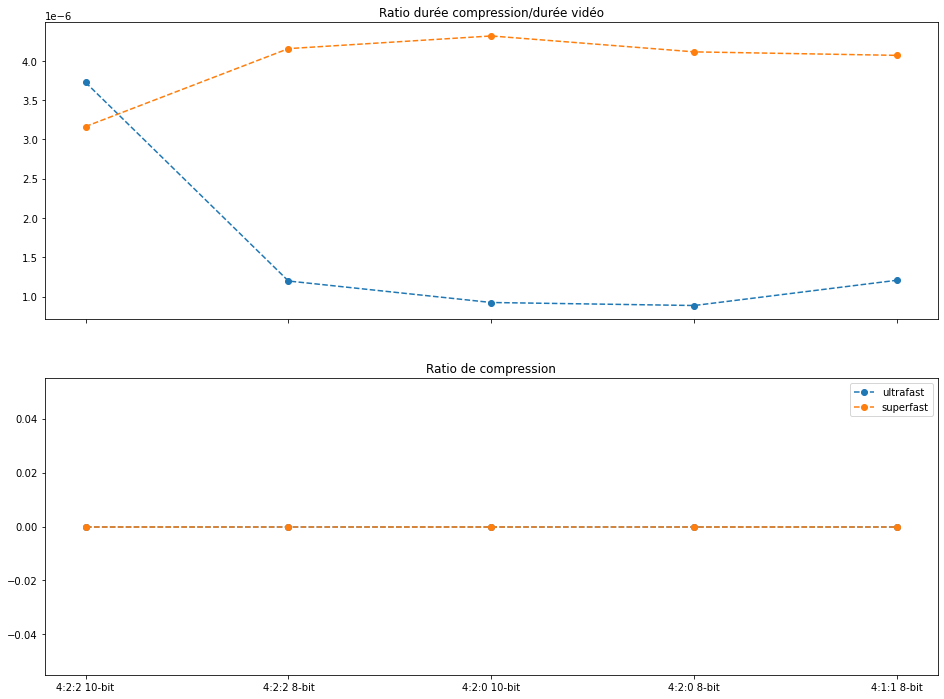

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Formats = ['4:2:2 10-bit', '4:2:2 8-bit', '4:2:0 10-bit', '4:2:0 8-bit', '4:1:1 8-bit']
Y = [0]*len(Durees)
for i in range(len(Durees)):
    Y[i] = Durees[i]/file_duration

mpl.rcParams['figure.figsize'] = [2.5*v for v in mpl.rcParamsDefault['figure.figsize']] # to get bigger figures

fig, (sub1, sub2) = plt.subplots(2, sharex = True)

sub1.plot(Formats, Y[:5], 'o--', label='ultrafast')
sub1.plot(Formats, Y[5:], 'o--', label='superfast')
sub1.set_title("Ratio durée compression/durée vidéo")

sub2.plot(Formats, Comp[:5], 'o--', label='ultrafast')
sub2.plot(Formats, Comp[5:], 'o--', label='superfast')
sub2.set_title("Ratio de compression")
plt.legend()

#### Écriture des résultats dans un fichier .json.

Éditer ce qu'on souhaite exporter.

In [48]:
import json

data_out = {}
data_out["parametres"] = Formats
data_out["tps_ultrafast"] = Y[:5]
data_out["comp_ultrafast"] = Comp[:5]
data_out["tps_superfast"] = Y[5:]
data_out["comp_ultrafast"] = Comp[:5]

with open(destination + '/results.json', 'w') as json_out: 
    json.dump(data_out, json_out, indent=4)